# 7.3.1 고급 구조 패턴

1. 배치 정규화(batch normalization)
    1. ```python normalized_data = (data - np.mean(data, axis = ...)) / np.std(data, axis = ...) ```
    2. 이전 예제에서는 모델에 데이터를 주입하기 전에 정규화 했으나, 데이터 정규화는 네트워크에서 일어나는 모든 변환 후에도 고려돼야 함 -> 배치 정규화 사용 이유
    3. 훈련 과정에 사용된 배치 데이터의 평균과 분산에 대한 지수 이동 평균(exponential moving average)을 내부에 유지 -> 잔차 연결과 매우 흡사하게 그래디언트의 전파를 도움(입력과 출력의 분포를 유지하도록 돕기 때문)
    4. 합성곱이나 완전 연결 층 다음에 사용
        1. Conv2D 층 다음에
            1. ```python
                 conv_model.add(layers.Conv2d(32, 3, activation='relu'))
                 conv_model.add(layers.BatchNormalization())
                ```
        2. Dense 층 다음에
            1. ```python
                 dense_model.add(layers.Dense(32, activation='relu'))
                 dense_model.add(layers.BatchNormalization())
                ```

* 배치 재정규화 (batch renormalization)

2. 깊이별 분리 합성곱(depthwise separable convolution)
    1. Conv2D보다 훈련할 모델 파라미터가 더 적고 부동 소수 연산이 더 적어 모델의 성능을 높일 수 있음
    2. 입력 채널별로 따로따로 공간 방향의 합성곱을 수행하고 점별 합성곱(1x1 합성곱)을 통해 출력 채널을 합쳐 출력
    3. 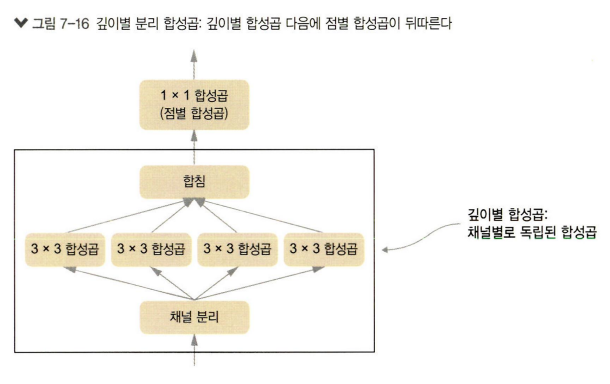
    4. 작은 데이터셋에서 이미지 분류 문제(softmax)를 위한 가벼운 깊이별 분리 컨브넷 예제 코드
    ```python
    from keras.models import Sequential, Model
    from keras import layers

    height = 64
    width = 64
    channels = 3
    num_classes = 10

    model = Sequential()
    model.add(layers.SeparableConv2D(32, 3, activation='relu', input_shape=(height, width, channels,)))
    model.add(layers.SeparableConv2D(64, 3, activation='relu'))
    model.add(layers.MaxPooling2D(2))

    model.add(layers.SeparableConv2D(64, 3, activation='relu'))
    model.add(layers.SeparableConv2D(128, 3, activation='relu'))
    model.add(layers.MaxPooling2D(2))

    model.add(layers.SeparableConv2D(64, 3, activation='relu'))
    model.add(layers.SeparableConv2D(128, 3, activation='relu'))
    model.add(layers.GlobalMaxPooling2D())

    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
    ```

# 7.3.2 하이퍼파라미터 최적화

1. 전형적인 하이퍼파라미터 최적화 과정
    1. 일련의 하이퍼파라미터를 자동으로 선택
    2. 선택된 하이퍼파라미터로 모델 만듦
    3. 훈련 데이터에 학습하고 검증 데이터에서 최종 성능 측정
    4. 다음으로 시도할 하이퍼파라미터를 자동으로 선택
    5. 위 과정 반복
    6. 마지막으로 테스트 데이터에서 성능 측정
2. 하이퍼파라미터를 업데이트 하는 게 어려운 이유
    1. 피드백 신호 계산 시 高비용, 多시간
    2. 연속적이지 않고 미분 가능하지 않기에 경사 하강법 사용 불가 -> 비효율적인 그래디언트 프리(gradient free) 사용
3. 보통 랜덤 탐색이 가장 좋은 경우가 많지만 Hyperopt를 사용하면 더 나음

# 7.3.3 모델 앙상블

1. 추론 시 나온 예측 평균
```python
preds_a = model_a.predict(x_val)
preds_b = model_b.predict(x_val)
preds_c = model_c.predict(x_val)
preds_d = model_d.predict(x_val)

   final_preds = 0.25 * (preds_a + preds_b + preds_c + preds_d) #새로운 예측은 어떤 초기 예측보다 정확해야 함
```
2. 검증 데이터에서 학습된 가중치를 사용하여 가중 평균
```python
preds_a = model_a.predict(x_val)
preds_b = model_b.predict(x_val)
preds_c = model_c.predict(x_val)
preds_d = model_d.predict(x_val)

   final_preds = 0.5 * preds_a + 0.25 * preds_b + 0.1 * preds_c + 0.15 * preds_d # 가중치는 경험적으로 학습됐다고 가정
```

가장 좋은 앙상블은 가능한 서로 다른 모델로 만드는 것(당연히 가능한 예측 성능이 높은 것 중에 고름)